# Import Libraries

In [1]:
# Only need to run this if `nibabel` is not installed

#!pip install nibabel

In [15]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import drive
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom
import random
import glob

In [ ]:
tf.__version__

'2.13.0'

In [ ]:
keras.__version__

'2.13.1'

## Mount Drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Switch Board
The following is a switch board which will allow you to determine whether to use sample dataset or full.

In [3]:
full_or_sample = input("[F]ull or [S]ample Dataset? ")
try:
  if full_or_sample[0].lower() == 'f':
      dataset_dir = "/content/drive/MyDrive/kits23-sample/dataset"
      dataset_folder_path = '/content/drive/MyDrive/kits23-sample/dataset'
  elif full_or_sample[0].lower() == 's':
      dataset_dir = "/content/drive/MyDrive/kits23-sample/dataset"
      dataset_folder_path = '/content/drive/MyDrive/kits23-sample/dataset'
  else:
    raise Exception()
except:
  print("Please use either [F] or [S]")

[F]ull or [S]ample Dataset? s


## Collection of Custom Functions

In [ ]:
# list all the files in a directory

import os
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(sub_indent, f))

# list_files(dataset_folder_path)

In [4]:
# obtain all the case names in a list for further downstream use
def get_all_case_dirs(root_path):
    """Get all case directories under the root path."""
    paths = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
    return paths

# safely load the data using the 'nibabel' library (used for visualising images and data-generator)
def safe_load_nii_gz_data(case_path, filename):
    """Load .nii.gz data using nibabel, return None if file doesn't exist."""
    file_path = os.path.join(case_path, filename)
    if os.path.exists(file_path):
        nii_data = nib.load(file_path)
        return nii_data.get_fdata(dtype = np.float16)
    else:
        print(f"File {file_path} not found.")
        return None

# visualize the absolute middle slice of a given case
def visualize_slice(data):
    """Visualize a slice of the 3D data."""
    plt.imshow(data[data.shape[0] // 2, :, :].T, cmap="gray")
    plt.show()

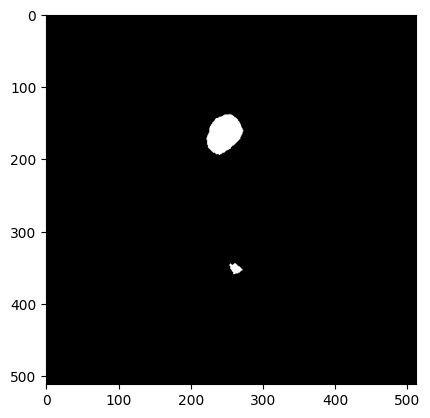

(190, 512, 512)
<class 'numpy.ndarray'>
Number of unique labels in segmentation file:  [0. 1. 2.]


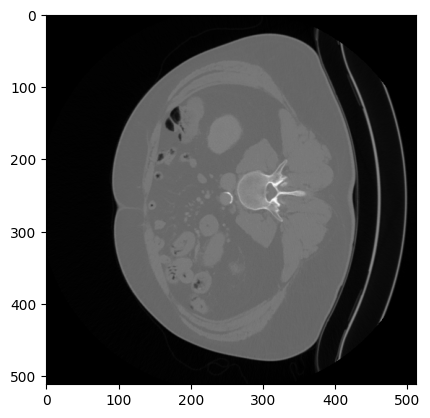

In [5]:
all_case_dirs = get_all_case_dirs(dataset_dir)
random.shuffle(all_case_dirs)
# Loading segmentations for the first few cases and visualize the first one that works
for case_dir in all_case_dirs[:1]:  # only testing first 10 for quick verification
    if case_dir.endswith('.ipynb_checkpoints') : continue
    segmentation_data = safe_load_nii_gz_data(case_dir, "segmentation.nii.gz")
    image_data = safe_load_nii_gz_data(case_dir, "imaging.nii.gz")
    if segmentation_data is not None:
        visualize_slice(segmentation_data)
        print(segmentation_data.shape)
        print(type(segmentation_data))
        print("Number of unique labels in segmentation file: ", np.unique(segmentation_data))
        visualize_slice(image_data)
        print(image_data.shape)

## Explicit Labels of Segmentation Data

In [8]:
seg_file = nib.load("/content/drive/MyDrive/kits23-sample/dataset/case_584/segmentation.nii.gz").get_fdata()
seg_file = seg_file.astype(np.uint8)

print(np.unique(seg_file))

[0 1 2]


#Filtering Out Incomplete Data

### Data Preparation

Cleaning the dataset by identifying and removing any cases that lack the segmentation.nii.gz file. If a case lacks segmentation.nii.gz, it implies that we don't have a reference segmentation for that particular case, making it unsuitable for training (since we wouldn't have a ground truth to compare the model's output to).

In [6]:
# List all cases
all_cases = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

In [7]:
# Filter cases that have segmentation.nii.gz and at least one instance
valid_cases = [
    case
    for case in all_cases
    if os.path.exists(os.path.join(dataset_dir, case, "segmentation.nii.gz")) and
    os.path.exists(os.path.join(dataset_dir, case, "imaging.nii.gz"))
]

print(f"Total cases: {len(all_cases)}")
print(f"Valid cases with segmentation and at least one instance: {len(valid_cases)}")

Total cases: 39
Valid cases with segmentation and at least one instance: 38


In [ ]:
# Print the names of the valid cases in order
print("\nNames of valid cases:")
for case_name in sorted(valid_cases):
    print(case_name)

In [ ]:
set(all_cases) - set(valid_cases)

{'.ipynb_checkpoints'}

In [ ]:
image_list = sorted(glob.glob("/content/drive/MyDrive/kits23-sample/dataset/*/imaging.nii.gz"))

#Data Preprocessing

### Find the average number of Z-axis slices to perform interpolation


In [ ]:
volumes = []

for i, case_dir in enumerate(all_cases):
    if case_dir.endswith('.ipynb_checkpoints') : continue
    # elif i == 5 : break
    segmentation_data = safe_load_nii_gz_data(case_dir, "imaging.nii.gz")
    print(case_dir, segmentation_data.shape)
    volumes.append(segmentation_data.shape[0])

average_slices = int(sum(volumes) / len(volumes))
print("Average number of slices: ", average_slices)

/content/drive/MyDrive/kits23-sample/dataset/case_4 (64, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_5 (834, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_6 (157, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_588 (248, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_7 (61, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_8 (227, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_9 (77, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_1 (50, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_11 (80, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_12 (89, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_13 (92, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_14 (439, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_15 (75, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/case_16 (178, 512, 512)
/content/drive/MyDrive/kits23-sample/dataset/cas

## Data Preprocessing
- one_hot_encoding |
    - returns a one-hot-encoding of the segmentation labels
- preprocess_data |
    - takes an image, determines whether the number of slices are less, equal or greater than target number of slices.
    - if less than target = interpolation (cubic) is used via 'zoom' function
    - if greater than target = downsampling is used by selecting a number of slices until target number of slices is achieved

In [8]:
def one_hot_encode(segmentation, num_classes):
    """
    One hot encodes the segmentation mask.
    Args:
    - segmentation : numpy array, the segmentation mask
    - num_classes : int, number of classes
    Returns:
    - one_hot : numpy array, the one-hot encoded mask
    """
    one_hot = np.zeros((*segmentation.shape, num_classes))
    for i in range(num_classes):
        one_hot[..., i] = (segmentation == i)
    return one_hot


In [9]:
def preprocess_data(image, label, target_num_slices = 256, num_classes=4):

    current_num_slices, height, width = image.shape

    # Calculate the scaling factor for Y and X dimensions
    y_scale_factor = 0.5
    x_scale_factor = 0.5

    # Upsample the Y and X dimensions using cubic interpolation
    resampled_volume = zoom(image, (1, y_scale_factor, x_scale_factor), order=3)

    if current_num_slices == target_num_slices:
        # No need to adjust the Z dimension
        pass

    elif current_num_slices < target_num_slices:
        # Upsample the Z dimension using cubic interpolation
        z_scale_factor = target_num_slices / current_num_slices
        resampled_volume = zoom(resampled_volume, (z_scale_factor, 1, 1), order=3)

    else:  # current_num_slices > target_num_slices
        # Downsample the Z dimension by selecting equidistant slices
        step_size = int(current_num_slices // target_num_slices)
        selected_slices = [resampled_volume[i, :, :] for i in range(0, current_num_slices, step_size)][:target_num_slices]
        resampled_volume = np.stack(selected_slices, axis=0)

    # Normalizing image data to [0, 1]
    scaler = MinMaxScaler()
    flattened_image = resampled_volume.reshape(-1, resampled_volume.shape[-1])
    normalized_image = scaler.fit_transform(flattened_image).reshape(resampled_volume.shape)

    visualize_slice(normalized_image)

    # One-hot encode the label
    one_hot_label = one_hot_encode(normalized_image, num_classes)

    return normalized_image, one_hot_label


#Generator : data is loaded and preprocessed on-the-fly during training

In [11]:
 #Each batch is consistent and has a shape (batch_size, 128, 128, 64, 1) for images and (batch_size, 128, 128, 64, num_classes) for labels
def data_generator(case_list, dataset_dir, batch_size=2, image_shape=(256, 256, 256, 1), num_classes=4):
    while True:
        # Randomly sample batch_size cases
        batch_cases = np.random.choice(case_list, size=batch_size)

        batch_images = []
        batch_labels = []

        for case in batch_cases:
            instances_dir = os.path.join(dataset_dir, case)

            # List all instance files within the directory
            all_files = os.listdir(instances_dir)

            # Filter out the kidney, cyst, and tumor instances
            image_files = [f for f in all_files if f.startswith("imaging")]

            # print(image_files)

            if not image_files:
                continue  # If there are no instance files, skip this case

            # Select a random instance for this case (assuming each case might have different instances)
            random_instance = np.random.choice(image_files)

            image_path = os.path.join(instances_dir, random_instance)
            label_path = os.path.join(dataset_dir, case, 'segmentation.nii.gz')

            # Load the image and label
            image = nib.load(image_path).get_fdata()
            label = nib.load(label_path).get_fdata()

            #print(np.unique(label))

            # Preprocess (resize and normalize) the image and label
            image, label = preprocess_data(image, label)

            # One-hot encode the labels
            #label = one_hot_encode(label, num_classes=num_classes)

            batch_images.append(image)
            batch_labels.append(label)

        # Ensure batch size consistency
        while len(batch_images) < batch_size:
            # simply reuse the data from the current batch. This is a basic approach, may change it
            batch_images.extend(batch_images[:batch_size - len(batch_images)])
            batch_labels.extend(batch_labels[:batch_size - len(batch_labels)])

        # Convert lists to numpy arrays and try to reshape them to ensure the consistency
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        # Print the shapes before reshaping
        # print("Shapes before reshaping:", batch_images.shape, batch_labels.shape)

        try:
            batch_images = batch_images.reshape((batch_size, *image_shape))
            batch_labels = batch_labels.reshape((batch_size, *image_shape[:-1], num_classes))
        except ValueError as e:
            print(f"Error reshaping for batch: {e}")
            print("Cases in the problematic batch:", batch_cases)
            continue  # Skip the problematic batch

        yield (batch_images, batch_labels)

#Splitting Dataset into Training and Validation

In [12]:
from sklearn.model_selection import train_test_split
train_cases, val_cases = train_test_split(valid_cases, test_size=0.1)  # Split 10% for validation

In [18]:
print(train_cases)

['case_586', 'case_4', 'case_8', 'case_12', 'case_584', 'case_29', 'case_582', 'case_15', 'case_25', 'case_11', 'case_579', 'case_14', 'case_5', 'case_6', 'case_1', 'case_7', 'case_9', 'case_26', 'case_23', 'case_583', 'case_581', 'case_588', 'case_13', 'case_3', 'case_17', 'case_22', 'case_585', 'case_18', 'case_28', 'case_587', 'case_24', 'case_21', 'case_19', 'case_58']


In [13]:
batch_size = 1  #change this value if needed

train_gen = data_generator(train_cases, dataset_dir, batch_size=batch_size)
val_gen = data_generator(val_cases, dataset_dir, batch_size=batch_size)

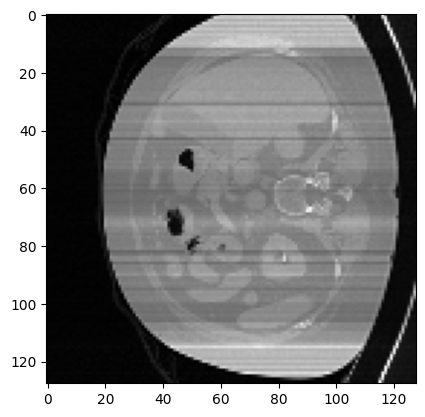

(1, 128, 128, 256, 1) (1, 128, 128, 256, 4)


In [14]:
x, y = next(train_gen)
print(x.shape, y.shape)

#Model

###Define the U-Net Model

In [33]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, Cropping3D
from keras.optimizers import Adam
from keras.metrics import MeanIoU

In [34]:
kernel_initializer =  'he_uniform'

In [36]:
#https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/simple_3d_unet.py

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    #model.summary()

    return model

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_DEPTH = 256
IMG_CHANNELS = 1
num_classes = 4

#Test if everything is working ok.
baseline_model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes)
print(baseline_model.input_shape)
print(baseline_model.output_shape)

(None, 256, 256, 256, 1)
(None, 256, 256, 256, 4)


##Define Losses, Metrics and Optimisers

In [37]:
# https://stackoverflow.com/questions/66023106/how-to-create-hybrid-loss-consisting-from-dice-loss-and-focal-loss-python

def dice_coef(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.nest.flatten(y_true)
    y_pred_f = tf.nest.flatten(y_pred)
    intersection = tf.math.reduce_sum(tf.math.multiply(y_true_f, y_pred_f))
    return (2. * intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[..., index], y_pred[..., index])
    return numLabels + dice

In [38]:
# It would be ideal to use IOUScore as another metric
metrics = ['accuracy', keras.metrics.MeanIoU(4)]

In [39]:
STEPS_PER_EPOCH = len(train_cases) // batch_size
lr = 0.0001

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  lr,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=10,
  staircase=False)

optimizer_Adam = Adam(learning_rate=lr_schedule)

#Train Model

## Set Up Callbacks

In [40]:
def create_model_cp_dir(model_name):
  if full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23-sample/CheckPointing"
  elif full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23/CheckPointing"
  leaf_directory = parent_directory + model_name + "/"
  full_directory = leaf_directory + model_name + ".{epoch:04d}-{val_loss:.4f}.ckpt"
  if not os.path.exists(leaf_directory):
    os.mkdir(leaf_directory)
  return full_directory

def create_saved_model_dir(model_name):
  if full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23-sample/SavedModels"
  elif full_or_sample[0].lower() : parent_directory = "/content/drive/MyDrive/kits23/SavedModels"
  leaf_directory = parent_directory + model_name + "/"
  full_directory = leaf_directory + model_name + ".h5"
  if not os.path.exists(leaf_directory):
    os.mkdir(leaf_directory)
  return full_directory

def get_callbacks(model_name):
  return [
    # tf.keras.callbacks.TensorBoard(logdir/str(model_name), histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(create_model_cp_dir(model_name),
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor = 'val_loss',
                                                 mode = 'min',
                                                 save_best_only = True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  ]

In [41]:
# Number of steps per epoch should be the number of batches of data  per epoch
steps_per_epoch = len(train_cases) // batch_size
validation_steps = len(val_cases) // batch_size  # similar calculation for validation data

## Compile Model

In [42]:
# We should include callbacks e.g. Early Stopping
baseline_model.compile(optimizer = optimizer_Adam,
              loss=dice_coef_multilabel,
              metrics=metrics)

This cell will take about 20 -30 mins to run.


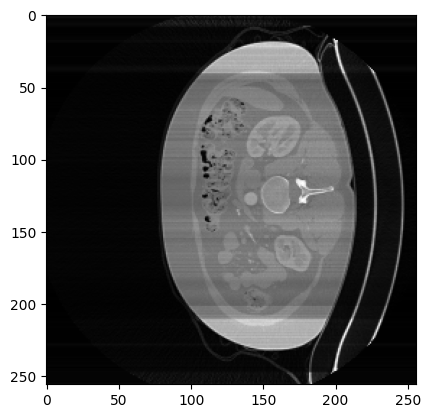

Epoch 1/10


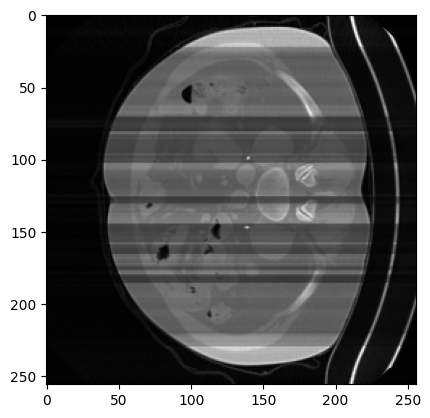

In [ ]:
baseline_history=baseline_model.fit(train_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=2,
          validation_data=val_gen,
          validation_steps=validation_steps,
          callbacks = [get_callbacks("baseline_sample_model")]
          )

# Plot Metrics

In [ ]:
loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = baseline_history.history['accuracy']
val_acc = baseline_history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



NameError: ignored